In [35]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import pickle
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN + FP) # 1-specificity - false positive rate
    
    return tpr, fpr

def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return tpr_list, fpr_list

def plot_roc_curve(tpr, fpr, scatter=True, ax=None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize=(5, 5))
        ax = plt.axes()
    
    if scatter:
        sn.scatterplot(x=fpr, y=tpr, ax=ax)
    sn.lineplot(x=fpr, y=tpr, ax=ax)
    sn.lineplot(x=[0, 1], y=[0, 1], color='green', ax=ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

def arg_median(x):
  return np.argpartition(x, len(x) // 2)[len(x) // 2]

def common_entries(*dcts):
    if not dcts:
        return
    for i in set(dcts[0]).intersection(*dcts[1:]):
        yield (i,) + tuple(d[i] for d in dcts)

data = "monograms"
selection = "AN"
model = "XG"

classes = ['Negative', 'Neutral', 'Positive']

In [36]:
with open(f"{data}/{selection}_{model}.pickle", "rb") as f:
    result_dict = pickle.load(f)

tst_score_list = result_dict["tst_score_list"]
y_tst_list = result_dict["y_tst_list"]
y_proba_list = result_dict["y_proba_list"]
arg_med = arg_median(tst_score_list)

med_auc = tst_score_list[arg_med]
med_y_tst = y_tst_list[arg_med]
med_y_proba = y_proba_list[arg_med]

{'Negative': 0.8237058080808081,
 'Neutral': 0.791841982234689,
 'Positive': 0.8697527314548591}


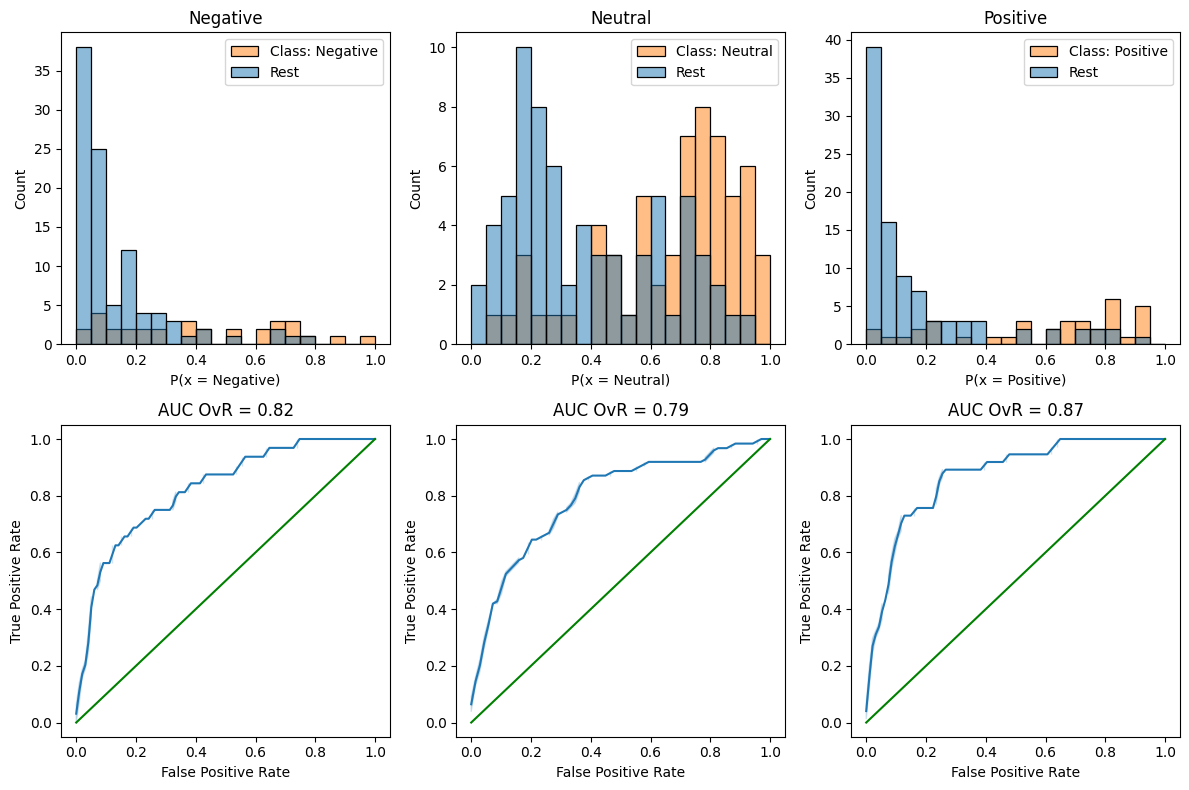

In [42]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}
for i, c in enumerate(classes):
    # Prepares an auxiliar dataframe to help with the plots
    aux_tst_class = [1 if y == i else 0 for y in med_y_tst]
    aux_tst_prob = med_y_proba[:, i]
    df_aux = pd.DataFrame(list(zip(aux_tst_class, aux_tst_prob)), columns=["class", "prob"])
    df_aux = df_aux.reset_index(drop = True)

    # Calculates the ROC AUC OvR
    auc = roc_auc_score(df_aux['class'], df_aux['prob'])
    roc_auc_ovr[c] = auc
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sn.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title(f"AUC OvR = {auc:.2f}")
    
    
plt.tight_layout()
plt.savefig(f"roc_{data}_{selection}_{model}.png")
pprint(roc_auc_ovr)